In [1]:
num_epoch = 500      
learning_rate = 0.002
batch_size = 1000

hidden_size = 16 #number of features in hidden state
num_layers = 3  #number of stacked lstm layers
bidirectional = True
drop_out = 0
bidirectional_forward_backward = 2 if bidirectional else 1

input_size = 41 #number of features
num_classes_attack_cat = 10 #number of output classes 
num_classes_label = 2       #number of output classes 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.autograd import Variable 

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
class Fake_DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)

        # preprocceing
        df.drop(["label"], axis=1, inplace=True)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

class Fake_DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)

        # preprocceing
        df.drop(["attack_cat"], axis=1, inplace=True)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

AxesSubplot(0.125,0.125;0.775x0.755)
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64
6    93000
5    58871
3    44525
4    24246
2    16353
7    13987
0     2677
1     2329
8     1511
9      174
Name: attack_cat, dtype: int64


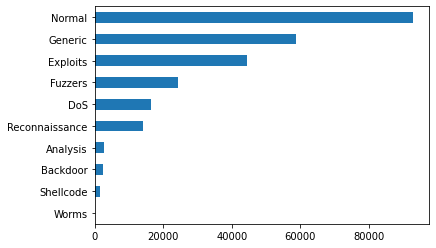

In [5]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

AxesSubplot(0.260833,0.125;0.503333x0.755)


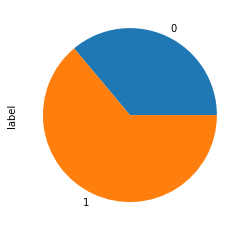

In [6]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

# **preprocessing ended**

# **create model**

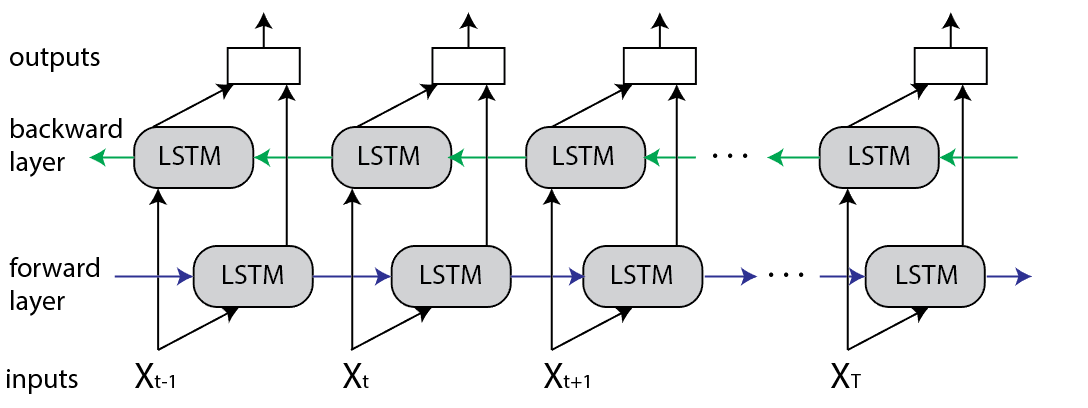

In [7]:
class LSTM_Model_attack(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_attack, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc = nn.Linear(hidden_size * bidirectional_forward_backward, num_classes) #fully connected last layer
                             # 2 => forward and backward for bidirectional
    
    def forward(self,x):
                                                # 2 => forward and backward for bidirectional
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :]) 
        return out


class LSTM_Model_label(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_label, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc = nn.Linear(hidden_size * bidirectional_forward_backward, num_classes) #fully connected last layer

    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :]) 
        return out


In [8]:
my_model_attack = LSTM_Model_attack(num_classes_attack_cat, input_size, hidden_size, num_layers).to(device=device)
my_model_attack

LSTM_Model_attack(
  (lstm): LSTM(41, 16, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [9]:
my_model_attack.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.1297, -0.0661, -0.1727,  ..., -0.2222,  0.0579, -0.1982],
                      [ 0.1941, -0.1632,  0.2121,  ...,  0.2073,  0.1871, -0.2355],
                      [-0.1160, -0.0620, -0.2092,  ..., -0.0237, -0.1911, -0.1910],
                      ...,
                      [ 0.0605,  0.2269,  0.0763,  ..., -0.1194, -0.0064,  0.0128],
                      [-0.0703,  0.2039,  0.1918,  ...,  0.0429, -0.0511,  0.2261],
                      [-0.1247, -0.1142, -0.0586,  ..., -0.0808, -0.2421,  0.1842]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.2284, -0.1631,  0.0364,  ...,  0.1375, -0.1366,  0.0931],
                      [ 0.1870, -0.0321,  0.1526,  ...,  0.0694, -0.0731, -0.2480],
                      [-0.2252,  0.2438, -0.0060,  ...,  0.1274, -0.0837, -0.0096],
                      ...,
                      [-0.2402, -0.0859,  0.2465,  ...,  0.1539, -0.0480, -0.07

In [10]:
my_model_label = LSTM_Model_label(num_classes_label, input_size, hidden_size, num_layers).to(device=device)
my_model_label

LSTM_Model_label(
  (lstm): LSTM(41, 16, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

# **optimizer and loss function**

In [11]:
loss_fn1 = nn.CrossEntropyLoss().to(device=device)
loss_fn2 = nn.CrossEntropyLoss().to(device=device)
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=learning_rate)
optimizer2 = opt.Adam(params=my_model_label.parameters(),lr=learning_rate)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

Epoch: 0, loss: 0.7943
Epoch: 50, loss: 0.4360
Epoch: 100, loss: 0.4294
Epoch: 150, loss: 0.4165
Epoch: 200, loss: 0.3745
Epoch: 250, loss: 0.4054
Epoch: 300, loss: 0.3946
Epoch: 350, loss: 0.3531
Epoch: 400, loss: 0.3595
Epoch: 450, loss: 0.3742
Epoch: 500, loss: 0.4322
Execution Time : 1247036.7500


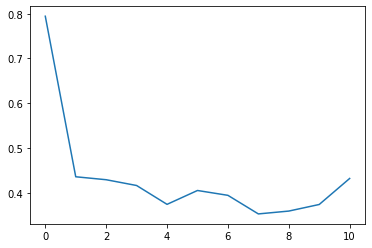

In [13]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x) , batch_y)
        loss1.backward() 
        optimizer1.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss1.item()))
         loss_plot.append(loss1.item())         

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test attack category with fake dataset**

In [14]:
dataset_attack_cat = Fake_DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/fake_UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)

    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)

print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

acc : 0.00%


In [16]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00    7500.0

    accuracy                           0.00    7500.0
   macro avg       0.00      0.00      0.00    7500.0
weighted avg       0.00      0.00      0.00    7500.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# **train label**

Epoch: 0, loss: 0.1670
Epoch: 50, loss: 0.1346
Epoch: 100, loss: 0.1118
Epoch: 150, loss: 0.1153
Epoch: 200, loss: 0.1275
Epoch: 250, loss: 0.1293
Epoch: 300, loss: 0.0844
Epoch: 350, loss: 0.1094
Epoch: 400, loss: 0.0932
Epoch: 450, loss: 0.0849
Epoch: 500, loss: 0.1061
Execution Time : 1259685.7500


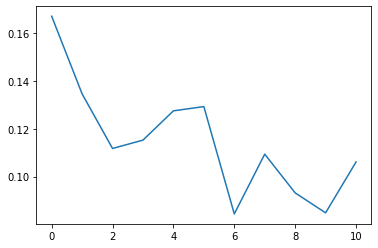

In [17]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_label_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer2.zero_grad()
        loss2 = loss_fn2(my_model_label(batch_x) , batch_y)
        loss2.backward() 
        optimizer2.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss2.item())) 
         loss_plot.append(loss2.item())         

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test label with fake dataset**

In [18]:
dataset_label = Fake_DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/fake_UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_label_dataloader:

    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_label(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)    

print("acc : %.2f" % (100.*correct / len(test_label)),end="")
print("%")

acc : 66.92%


Confusion matrix, without normalization
[[5019 2481]
 [   0    0]]


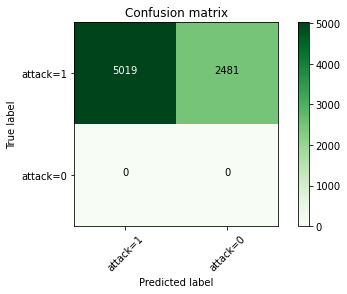

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['attack=1','attack=0'],normalize= False,  title='Confusion matrix')

In [20]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80      7500

    accuracy                           0.67      7500
   macro avg       0.50      0.33      0.40      7500
weighted avg       1.00      0.67      0.80      7500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
